# Joining tabular and vector data in Python

This notebook shows how you can supplement tabular data with spatial data using Python's popular data science libraries.  
The data used in this example cover COVID-19 vaccination in Poland by voivodships.

### Dependencies:
- requests
- pandas
- geopandas
- matplotlib

## Get vaccination data
source: http://www.bit.ly/SzczepieniaCOVID19 

In [10]:
import pandas as pd

In [11]:
url_vacc = 'https://docs.google.com/spreadsheets/d/19DqluO7mmKrheqBDRD2ZFM2ZLSi4YTW2nwLbPHkiTYU/export?format=csv&gid=0'

### Preprocess raw tabular data

In [12]:
raw_data = pd.read_csv(url_vacc, header=None, skip_blank_lines=False)
raw_data = raw_data.drop(columns=raw_data.columns[-1])

header = pd.MultiIndex.from_arrays(row.ffill()
    for i, row in raw_data[:3].iterrows())

raw_data = raw_data[3:]
raw_data.columns = header

raw_data = raw_data.filter(regex='całkowicie', axis='columns')
raw_data = raw_data.droplevel([0,2], axis=1)
raw_data = raw_data.drop(columns=raw_data.columns[0])

if len(raw_data.columns) != 16:
    raise Exception('Incorrect number of columns (voyevodships)')

raw_data.tail(3)

1,dolnośląskie,kujawsko-pomorskie,lubelskie,lubuskie,łódzkie,małopolskie,mazowieckie,opolskie,podkarpackie,podlaskie,pomorskie,śląskie,świętokrzyskie,warmińsko-mazurskie,wielkopolskie,zachodniopomorskie
322,1 421 776,956 356,825 275,486 428,1 178 123,1 515 212,2 804 951,421 035,764 807,511 907,1 176 493,2 119 073,512 764,613 643,1 722 765,817 646
323,1 422 520,956 814,826 363,486 674,1 178 928,1 516 334,2 806 687,421 286,765 419,512 503,1 177 256,2 120 321,513 226,614 075,1 723 979,818 303
324,1 422 798,957 054,826 594,486 821,1 179 247,1 516 760,2 807 624,421 352,765 587,512 645,1 177 607,2 120 880,513 370,614 193,1 724 342,818 532


### Get latest figures

In [13]:
def to_int(string):
    res = ''
    for n in string:
        if n.isnumeric():
            res += n
    return int(res)

current_data = raw_data.iloc[-1]  # last row
woj_vacc = pd.DataFrame(current_data)
woj_vacc.reset_index(inplace=True)
woj_vacc.columns = ['name', 'vaccinated']
woj_vacc['vaccinated'] = woj_vacc.vaccinated.apply(to_int)
woj_vacc

,name,vaccinated
0,dolnośląskie,1422798
1,kujawsko-pomorskie,957054
2,lubelskie,826594
3,lubuskie,486821
4,łódzkie,1179247
5,małopolskie,1516760
6,mazowieckie,2807624
7,opolskie,421352
8,podkarpackie,765587
9,podlaskie,512645


## Get population data

Data source: Główny Urząd Statystyczny

### Connect to server and get data

In [14]:
import requests
import json

year = '2020'
url_population = f'https://bdl.stat.gov.pl/api/v1/data/by-variable/72305?format=json&year={year}&unit-level=2&page-size=20'
response = requests.get(url_population)

if not response.ok:
    raise Exception(f'Error getting population data. Reason: {response.reason}, code: {response.status_code}')

population_json = json.loads(response.text)  #! nested JSON

### Process JSON with population data

In [15]:
nested = pd.json_normalize(population_json, record_path=['results'], record_prefix='x')         # pop vals are burried in 'results'
population = nested.xvalues.apply(lambda lst: lst.pop()).apply(pd.Series).filter(items=['val']) # under the key 'values' in a list
                                                                                                # of dicts for each requested year
woj_population = pd.concat([nested, population], axis=1)
woj_population = woj_population.filter(items=['xname', 'val'])
woj_population.columns = ['name', 'population']
woj_population.name = woj_population.name.apply(lambda str: str.lower())
woj_population

,name,population
0,małopolskie,3410441
1,śląskie,4492330
2,lubuskie,1007145
3,wielkopolskie,3496450
4,zachodniopomorskie,1688047
5,dolnośląskie,2891321
6,opolskie,976774
7,kujawsko-pomorskie,2061942
8,pomorskie,2346671
9,warmińsko-mazurskie,1416495


### Merge total population with numbers of vaccinated people

In [16]:
woj_data = pd.merge(woj_vacc, woj_population, how='left', on='name')
woj_data

,name,vaccinated,population
0,dolnośląskie,1422798,2891321
1,kujawsko-pomorskie,957054,2061942
2,lubelskie,826594,2095258
3,lubuskie,486821,1007145
4,łódzkie,1179247,2437970
5,małopolskie,1516760,3410441
6,mazowieckie,2807624,5425028
7,opolskie,421352,976774
8,podkarpackie,765587,2121229
9,podlaskie,512645,1173286


### Calculate percentage

In [17]:
woj_data['pct'] = (woj_data.vaccinated / woj_data.population) * 100
woj_data

,name,vaccinated,population,pct
0,dolnośląskie,1422798,2891321,49.209271
1,kujawsko-pomorskie,957054,2061942,46.415176
2,lubelskie,826594,2095258,39.450702
3,lubuskie,486821,1007145,48.336734
4,łódzkie,1179247,2437970,48.370037
5,małopolskie,1516760,3410441,44.474014
6,mazowieckie,2807624,5425028,51.753171
7,opolskie,421352,976774,43.137102
8,podkarpackie,765587,2121229,36.091671
9,podlaskie,512645,1173286,43.693098


## Get vector data from WFS

In [18]:
wfs_url = 'https://mapy.geoportal.gov.pl/wss/service/PZGIK/PRG/WFS/AdministrativeBoundaries'

### Connect to WFS service and display informations [optional]

In [ ]:
from owslib.wfs import WebFeatureService

wfs = WebFeatureService(url=wfs_url, version='2.0.0')

print(wfs.identification.title)
print([operation.name for operation in wfs.operations])
print(list(wfs.contents))

### Prepare query url

In [19]:
import requests

In [20]:
layer_name = 'ms:A01_Granice_wojewodztw'
params = dict(service='WFS', version='2.0.0', request='GetFeature',
              typeName=layer_name, typeNames=layer_name,
              srsName='urn:ogc:def:crs:EPSG::2180')

query_url = requests.Request('GET', wfs_url, params=params).prepare().url
print(query_url)

https://mapy.geoportal.gov.pl/wss/service/PZGIK/PRG/WFS/AdministrativeBoundaries?service=WFS&version=2.0.0&request=GetFeature&typeName=ms%3AA01_Granice_wojewodztw&typeNames=ms%3AA01_Granice_wojewodztw&srsName=urn%3Aogc%3Adef%3Acrs%3AEPSG%3A%3A2180


### Get and load GML into a data frame

In [21]:
import io
import geopandas as gpd

r = requests.get(query_url)

if not r.ok:
    raise Exception(
        f'Error getting population data. Reason: {r.reason}, code: {r.status_code}')

gml = io.BytesIO(r.content)
woj_fc = gpd.read_file(gml, driver='GML')


In [24]:
woj_fc = woj_fc[['JPT_KOD_JE', 'JPT_NAZWA_', 'geometry']]
woj_fc.columns = ['teryt','name','geometry']
woj_fc

,teryt,name,geometry
0,32,zachodniopomorskie,"POLYGON ((225874.333 694332.554, 224490.655 69..."
1,08,lubuskie,"POLYGON ((248735.538 411101.949, 248747.463 41..."
2,02,dolnośląskie,"POLYGON ((248735.538 411101.949, 248788.652 41..."
3,30,wielkopolskie,"POLYGON ((347736.460 606210.458, 347712.257 60..."
4,22,pomorskie,"POLYGON ((414159.332 769636.478, 413135.067 76..."
5,16,opolskie,"POLYGON ((433111.801 248899.570, 433255.322 24..."
6,04,kujawsko-pomorskie,"POLYGON ((411073.728 634866.912, 411071.347 63..."
7,24,śląskie,"MULTIPOLYGON (((433111.801 248899.570, 433055...."
8,10,łódzkie,"POLYGON ((606077.660 401119.775, 605989.236 40..."
9,12,małopolskie,"POLYGON ((655913.857 247933.512, 655911.673 24..."


## Merge tabular and spatial data

In [25]:
woj = pd.merge(woj_fc, woj_data, how='left', on='name')

### Save to shp [optional]

In [ ]:
woj.set_crs(epsg=2180, allow_override=True)
woj.to_file("woj_szczepienia.shp", encoding='utf-8')

## Display map

In [131]:
import matplotlib.pyplot as plt
from datetime import datetime

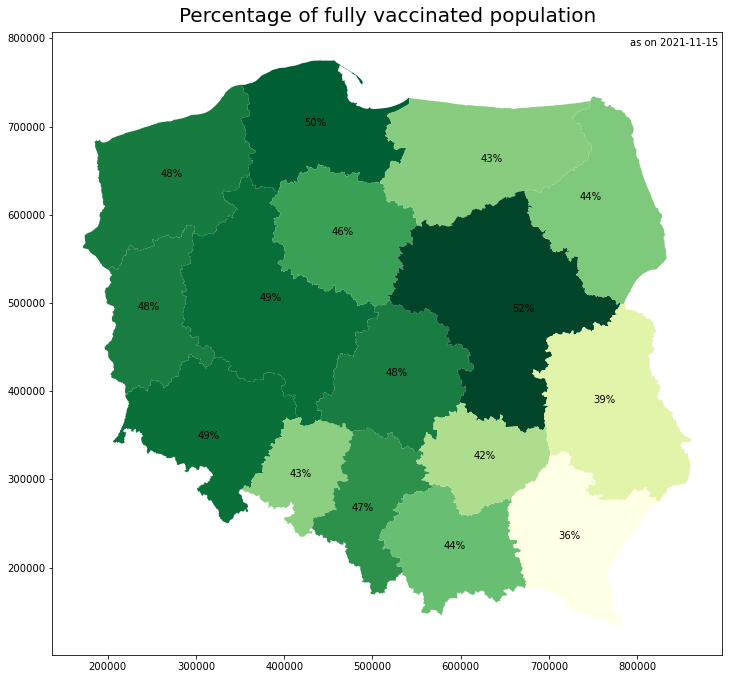

In [197]:
today = datetime.today().strftime("%Y-%m-%d")

woj['label_coords'] = woj['geometry'].apply(
    lambda geom: geom.representative_point().coords[0])  # label coordinates


plot = woj.plot('pct', cmap='YlGn', figsize=(12, 12))
plt.title('Percentage of fully vaccinated population',
                 fontdict={'fontsize':20}, 
                 pad=10)

txt_params = dict(ha="right", va="top", fontsize=10, transform=plot.transAxes)
plt.text(x=0.995, y=0.99, s=f'as on {today}', **txt_params)

for idx, row in woj.iterrows():
    label = f'{row["pct"]:.0f}%'
    plot.annotate(text=label, xy=row['label_coords'],
                 horizontalalignment='center')
